# Car Image Embedding and Subsampling

In [7]:
%matplotlib inline

In [63]:
data_dir = 'data'
collection = 'pascal-voc-2012'
annotation_file = 'ImageSets/Main/car_trainval.txt'
width = 320
height = 240

In [64]:
target_size = width * height
target_aspect_ratio = width / height
img_dir = f'{data_dir}/{collection}/JPEGImages'
cars_dir = f'{data_dir}/{collection}-cars'

In [10]:
from imageio import imread

positives = {}
positives_gray = {}

with open(f'{data_dir}/{collection}/{annotation_file}', 'r') as f:
    lines = f.readlines()

    for line in lines: 
        filename, label = line.strip().split()
        
        if label == '1':
            positives[filename] = imread(f'{img_dir}/{filename}.jpg')
            positives_gray[filename] = imread(f'{img_dir}/{filename}.jpg', as_gray=True)

print(f'Found {len(positives)} car images')

Found 1161 car images


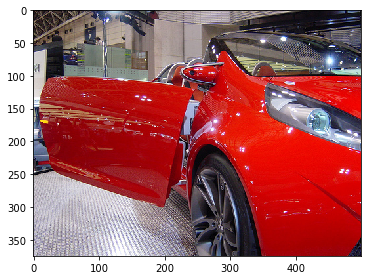

In [11]:
from skimage.io import imshow
imshow(positives['2008_000027'])

## Resize and save images

In [17]:
import math
import numpy as np
from pathlib import Path
from PIL import Image
from skimage.transform import resize

Path(cars_dir).mkdir(parents=True, exist_ok=True)

min_size = width * height

final_imgs = []
scaled_imgs = []
scaled_imgs_color = []

for filename in positives:
    img = positives[filename]
    img_gray = positives_gray[filename]
    h, w = img_gray.shape
    size = w * h
    aspect_ratio = w / h
    if w >= width and h >= height:
        if aspect_ratio > 1:
            # Landscape
            if aspect_ratio > target_aspect_ratio:
                # Wider than the target so we scale by height
                scale_factor = height / h
                nh = height
                nw = round(w * scale_factor)
                
            else:
                # Taller than the target so we scale by width
                scale_factor = width / w
                nh = round(h * scale_factor)
                nw = width
            
            scaled_img = resize(img, (nh, nw), anti_aliasing=False)
            scaled_img_gray = resize(img_gray, (nh, nw), anti_aliasing=False)
            
            xOffset = math.floor((nw - width) / 2)
            yOffset = math.floor((nh - height) / 2)
            
            scaled_img = scaled_img[yOffset:yOffset+height, xOffset:xOffset+width]
            scaled_img_gray = scaled_img_gray[yOffset:yOffset+height, xOffset:xOffset+width]
            
        else:
            adjusted_aspect_ratio = 1 / target_aspect_ratio

            # Portrait
            if aspect_ratio > adjusted_aspect_ratio:
                # Wider than the target so we scale by height
                scale_factor = height / w
                nh = width
                nw = round(w * scale_factor)
                
            else:
                # Taller than the target so we scale by width
                scale_factor = width / h
                nh = round(h * scale_factor)
                nw = height
            
            scaled_img = resize(img, (nh, nw), anti_aliasing=False)
            scaled_img_gray = resize(img_gray, (nh, nw), anti_aliasing=False)
            
            xOffset = math.floor((nw - height) / 2)
            yOffset = math.floor((nh - width) / 2)
            
            scaled_img = scaled_img[yOffset:yOffset+width, xOffset:xOffset+height]
            scaled_img_gray = scaled_img_gray[yOffset:yOffset+width, xOffset:xOffset+height]
            
        rh, rw = scaled_img_gray.shape
        
        if rh * rw == target_size:
            final_imgs.append(filename)
            scaled_imgs.append(scaled_img_gray.flatten())
            scaled_imgs_color.append(scaled_img)
            scaled_img *= 255
            Image.fromarray(scaled_img.astype(np.uint8)).save(f'{cars_dir}/{filename}.jpg', quality=75)
        else:
            print(f'{filename} with {rw}x{rh} == {rh*rw}')

scaled_imgs = np.vstack(scaled_imgs)

n, dim = scaled_imgs.shape

print(f'Final number of cropped and resized images is {n}')

Final number of cropped and resized images is 1161


## Test SSIM

In [122]:
from skimage.metrics import structural_similarity as ssim
from itertools import combinations
import numpy as np
import time

norm_scaled_imgs = scaled_imgs / 255.0

num_combinations = (n * (n - 1)) / 2
print(f'{num_combinations} pairwise distances need to be computed')

s = time.time()
k = 100
t = 0
for i, c in enumerate(combinations(np.arange(n), 2)):
    if i % k == k - 1:
        t = time.time() - s
        print(f'{k} computations took {t:.2f} sec')
        break
    ssim(norm_scaled_imgs[c[0]], norm_scaled_imgs[c[1]], data_range=1.0)

total_time = num_combinations / k * t / 60

print(f'Total time will take about {total_time:.1f} mins')

651511.0 pairwise distances need to be computed
100 computations took 0.31 sec
Total time will take about 34.1 mins


In [123]:
dist_ssim = np.zeros((n, n))

l = 0
for k, c in enumerate(combinations(np.arange(n), 2)):
    if k % 10000 == 9999:
        l += 1
        print(f'{l},', end='', flush=True)
        
    i, j = c
    d = ssim(norm_scaled_imgs[i], norm_scaled_imgs[j], data_range=1.0)
    dist_ssim[i,j] = d
    dist_ssim[j,i] = d

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,

## Compute AE

In [38]:
import ae

encoder, autoencoder = ae.create(drawings=False)

autoencoder.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 8, 8, 8)           1160      
_________________________________________________________________
conv3 (Conv2D)               (None, 4, 4, 8)           584       
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense1 (Dense)               (None, 32)                4128      
_________________________________________________________________
dense2 (Dense)               (None, 16)                528

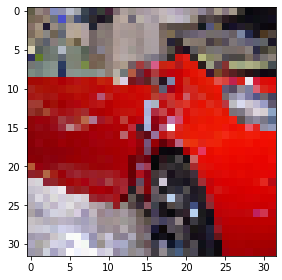

In [26]:
img_array = np.vstack(scaled_imgs_color).reshape((-1,32,32,3)).astype(np.uint8)
imshow(img_array[0])

In [40]:
norm_img_array = img_array.copy()
norm_img_array = norm_img_array.astype(np.float)
norm_img_array /= 255.0
n = img_array.shape[0]
permutations = np.random.permutation(n)

subsample = 1.0
train_fraction = 0.9
train = permutations[:int(train_fraction * subsample * n)]
test = permutations[int(train_fraction * subsample * n):int(subsample * n)]

x_train = norm_img_array[train]
x_test = norm_img_array[test]

print(f'Total dataset size: {n}')
print(f'Train size: {train.shape[0]}')
print(f'Test size: {test.shape[0]}')

Total dataset size: 1161
Train size: 1044
Test size: 117


In [42]:
tqdm_keras = ae.get_tqdm(is_keras=True)

autoencoder.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(x_test, x_test),
    verbose=0,
    callbacks=[tqdm_keras(leave_inner=True, leave_outer=False)],
)

In [52]:
encoded_imgs = encoder.predict(norm_img_array)

from umap import UMAP

umap_ae = UMAP(n_neighbors=5).fit_transform(encoded_imgs)

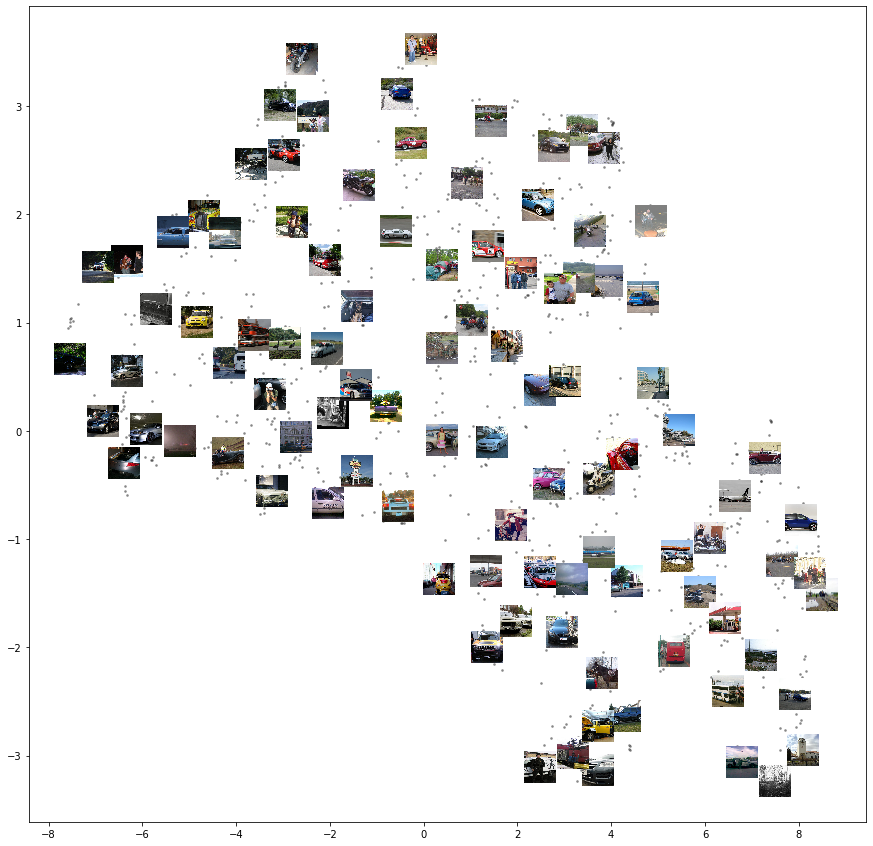

In [55]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.cluster import KMeans

embedding_clusters = KMeans(100).fit_transform(umap_ae)
centers = np.argmin(embedding_clusters, axis=0)

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(umap_ae[:,0], umap_ae[:,1], s=3, alpha=0.33, color='#000000')

for c in centers:
    ax.add_artist(AnnotationBbox(OffsetImage(img_array[c].reshape((32, 32, 3))), umap_ae[c], frameon=False))

## Compute Embedding

In [56]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP

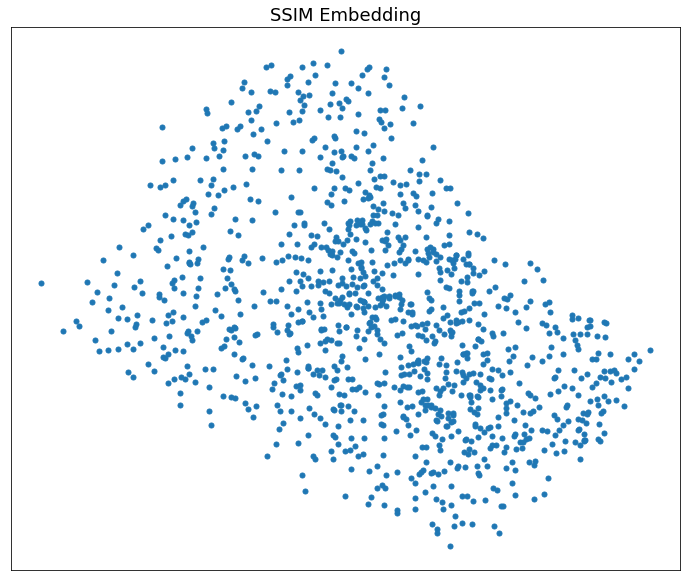

In [152]:
umap_ssim = UMAP(n_neighbors=5, metric='precomputed').fit_transform(np.abs(dist_ssim))

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(umap_ssim[:, 0], umap_ssim[:, 1], s=25)
plt.setp(ax, xticks=[], yticks=[])
plt.title("SSIM Embedding", fontsize=18)
plt.show()

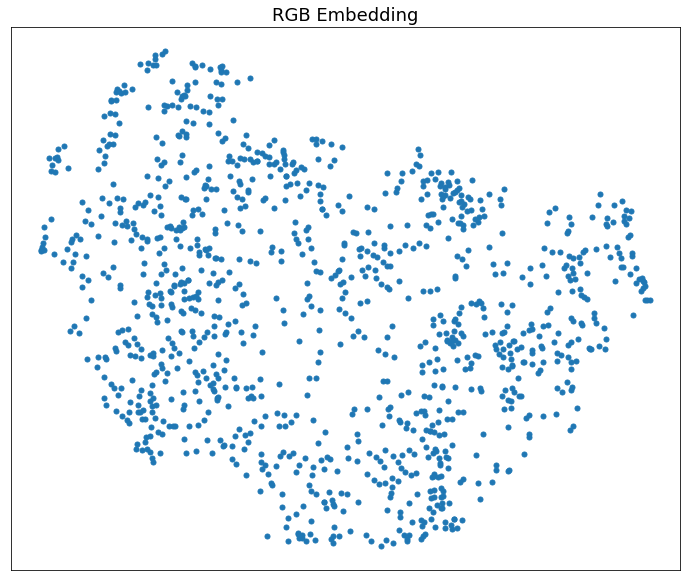

In [154]:
umap_rgb = UMAP(n_neighbors=5).fit_transform(norm_scaled_imgs)

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(umap_rgb[:, 0], umap_rgb[:, 1], s=25)
plt.setp(ax, xticks=[], yticks=[])
plt.title("RGB Embedding", fontsize=18)
plt.show()

In [155]:
scaler = MinMaxScaler((0.05, 0.95))
umap_rgb_scaled = scaler.fit_transform(umap_rgb) 
umap_ssim_scaled = scaler.fit_transform(umap_ssim)
umap_ae_scaled = scaler.fit_transform(umap_ae)

## Save Data

In [156]:
out_img_dir = 'data/pascal-voc-2012-cars'

data = []

for i in range(umap_ssim_scaled.shape[0]):
    item = {}
    item['src'] = f'{out_img_dir}/{final_imgs[i]}.jpg'
    item['umapRgb'] = umap_rgb_scaled[i].tolist()
    item['umapSsim'] = umap_ssim_scaled[i].tolist()
    item['umapAe'] = umap_ae_scaled[i].tolist()
    data.append(item)